# Assess the runoffs over the Arctic basin

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib.colors as mcolors

%matplotlib inline

/appli/conda-env/3.6/pangeo/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/appli/conda-env/3.6/pangeo/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [4]:
! date

Fri Mar 24 10:12:17 GMT 2023


>> # Read CREG025.L75 grid

In [5]:
#ds_grd=xr.open_dataset('./CREG025.L75-NEMO420_tmask.nc')
ds_dfg=xr.open_dataset('./CREG025.L75_domain_cfg.nc')

In [6]:
ds_dfg

<xarray.Dataset>
Dimensions:       (t: 1, x: 528, y: 603, z: 75)
Dimensions without coordinates: t, x, y, z
Data variables:
    nav_lon       (y, x) float32 ...
    nav_lat       (y, x) float32 ...
    nav_lev       (z) float32 ...
    time_counter  (t) float64 ...
    jpiglo        int32 ...
    jpjglo        int32 ...
    jpkglo        int32 ...
    jperio        int32 ...
    ln_zco        int32 ...
    ln_zps        int32 ...
    ln_sco        int32 ...
    ln_isfcav     int32 ...
    glamt         (t, y, x) float64 ...
    glamu         (t, y, x) float64 ...
    glamv         (t, y, x) float64 ...
    glamf         (t, y, x) float64 ...
    gphit         (t, y, x) float64 ...
    gphiu         (t, y, x) float64 ...
    gphiv         (t, y, x) float64 ...
    gphif         (t, y, x) float64 ...
    e1t           (t, y, x) float64 ...
    e1u           (t, y, x) float64 ...
    e1v           (t, y, x) float64 ...
    e1f           (t, y, x) float64 ...
    e2t           (t, y, x) fl

In [7]:
# Define a land-sea mask in an other way
tmask2D=xr.where(ds_dfg['bottom_level']>0,1.,0.)

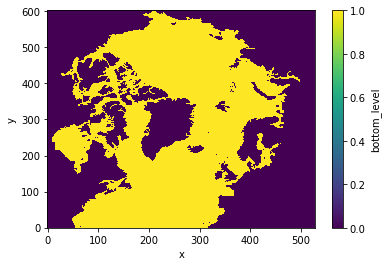

In [8]:
tmask2D.plot()

>> # Read ISBA runoffs data

In [9]:
DATAIN='/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/FREDY/RUNS/CREG025.L75/DATA_FORCING/RUNOFFS/ISBA/ALL-LEAP/'
ds_isbarnf=xr.open_mfdataset(DATAIN+'runoff_ISBA_daily_CREG025.L75-NEMO420_y*.nc',concat_dim='time_counter')

In [10]:
ds_isbarnf

<xarray.Dataset>
Dimensions:       (time_counter: 16436, x: 528, y: 603)
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 1979-01-01T12:00:00 ... 1981-12-31T12:00:00
Dimensions without coordinates: x, y
Data variables:
    nav_lon       (time_counter, y, x) float32 dask.array<shape=(16436, 603, 528), chunksize=(365, 603, 528)>
    nav_lat       (time_counter, y, x) float32 dask.array<shape=(16436, 603, 528), chunksize=(365, 603, 528)>
    sorunoff      (time_counter, y, x) float32 dask.array<shape=(16436, 603, 528), chunksize=(365, 603, 528)>
    socoefr       (time_counter, y, x) float32 dask.array<shape=(16436, 603, 528), chunksize=(365, 603, 528)>

>> # Read Dai & Trenberth & Bamber runoffs data

In [11]:
DATAIN='/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/FREDY/RUNS/CREG025.L75/DATA_FORCING/RUNOFFS/IA/'
ds_DTBrnf=xr.open_mfdataset(DATAIN+'CREG025_runoff_monthly_combined_Dai_Trenberth_Bamber_y*.nc')

In [12]:
ds_DTBrnf

<xarray.Dataset>
Dimensions:       (time_counter: 744, x: 528, y: 603)
Coordinates:
  * time_counter  (time_counter) object 1958-01-15 00:00:00 ... 2007-12-16 00:00:00
Dimensions without coordinates: x, y
Data variables:
    nav_lon       (time_counter, y, x) float32 dask.array<shape=(744, 603, 528), chunksize=(12, 603, 528)>
    nav_lat       (time_counter, y, x) float32 dask.array<shape=(744, 603, 528), chunksize=(12, 603, 528)>
    socoefr       (time_counter, y, x) float32 dask.array<shape=(744, 603, 528), chunksize=(12, 603, 528)>
    runoff        (time_counter, y, x) float32 dask.array<shape=(744, 603, 528), chunksize=(12, 603, 528)>
Attributes:
    source:   combined Dai & Trenberth and Bamber (totalFWtoRunoffRatio=0.46)...

# Define a proper Arctic box following Haine et al. GPC2015

In [13]:
# Define a proper Arctic box following Haine et al. GPC2015
# including all Arctic area + CAA + north to Davis, FRAM and Bering straits as east to BSO
tmskBFGBIG=xr.where(ds_dfg['gphit'] < 62.,0., tmask2D)
# Remove the Baffin bay area
tmskBFGBIG=xr.where((ds_dfg['glamt'] >= -90.) & (ds_dfg['glamt'] < -45.) & (ds_dfg['gphit'][:,:] <= 80.), 0., tmskBFGBIG )
# Adjust the Baffin bay area north to Davis Strait 66.25N
tmskBFGBIG=xr.where((ds_dfg['glamt'] >= -70.) & (ds_dfg['glamt'] < -45.) & (ds_dfg['gphit'] >= 62.) & (ds_dfg['gphit'] < 66.25), 0., tmskBFGBIG) 
tmskBFGBIG=xr.where((ds_dfg['glamt'] >= -70.) & (ds_dfg['glamt'] < -65.) & (ds_dfg['gphit'] >= 66.25) & (ds_dfg['gphit'] < 67.) , 0., tmskBFGBIG)
# Remove all GIN seas area
tmskBFGBIG=xr.where((ds_dfg['glamt'] < 17.) & (ds_dfg['glamt'] > -45.) & (ds_dfg['gphit'] < 79.), 0., tmskBFGBIG)
# Remove Hudson area
tmskBFGBIG=xr.where((ds_dfg['glamt'] < -70.) & (ds_dfg['glamt'] > -82. ) & (ds_dfg['gphit'] < 70.5), 0., tmskBFGBIG)
tmskBFGBIG=xr.where((ds_dfg['glamt'] <= -82.) & (ds_dfg['glamt'] > -100.) & (ds_dfg['gphit'] < 67.), 0., tmskBFGBIG)
# Adriatic area 
tmskBFGBIG=xr.where((ds_dfg['glamt'] < 30.) & (ds_dfg['glamt'] > 17.) & (ds_dfg['gphit'] < 68.), 0., tmskBFGBIG)


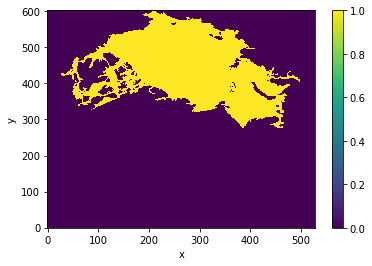

In [14]:
tmskBFGBIG.plot()

In [15]:
# Remove also the ACC area
tmskBFGBIG=xr.where((ds_dfg['glamt'] < -60.) & (ds_dfg['glamt'] > -120. ) & (ds_dfg['gphit'] < 80), 0., tmskBFGBIG)

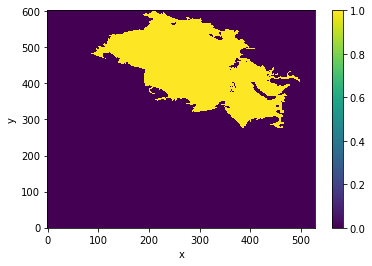

In [16]:
tmskBFGBIG.plot()

In [17]:
# Remove also the ACC area
tmskBFGBIG=xr.where((ds_dfg['glamt'] < -120.) & (ds_dfg['glamt'] > -125. ) & (ds_dfg['gphit'] < 75), 0., tmskBFGBIG)
tmskBFGBIG=xr.where((ds_dfg['glamt'] < -60.) & (ds_dfg['glamt'] > -90. ) & (ds_dfg['gphit'] < 83), 0., tmskBFGBIG)

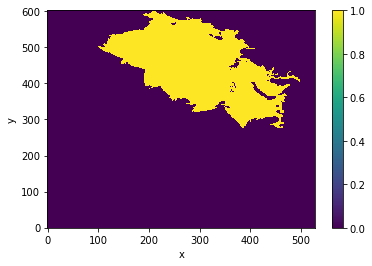

In [18]:
tmskBFGBIG.plot()

In [19]:
# To convert Sv to km3/year
alpha=1e-9*365*86400.*1e6

# Compute the sum over the CREG domain

### > ISBA data set

In [20]:
isba_syear=1978 ; isba_eyear=2022
ds_rnf_daily=xr.Dataset()
ds_rnf_daily['sorunoff_sum']=(('time_counter'),((ds_isbarnf['sorunoff'][:,:,:]*tmskBFGBIG[0,:,:]*\
                                                ds_dfg['e1t'].isel(t=0)*\
                                                ds_dfg['e2t'].isel(t=0))*1e-3).sum(dim=['x','y'])*1e-6)
ds_rnf_daily.coords['time_counter']=pd.date_range(start=str(isba_syear)+'-01-01',end=str(isba_eyear)+'-12-31',freq='D')
ds_rnf_daily['sorunoff_sum'].attrs={'units':'Sv'}

In [21]:
ds_rnf_mon=xr.Dataset()

ds_rnf_mon['sorunoff_sum']=(('time_counter'),ds_rnf_daily['sorunoff_sum'].resample(time_counter="1M").mean())
ds_rnf_mon.coords['time_counter']=pd.date_range(start=str(isba_syear)+'-01',end=str(isba_eyear)+'-12',freq='MS')+\
                                     pd.DateOffset(days=14)
ds_rnf_mon['sorunoff_sum'].attrs={'units':'Sv'}

In [22]:
ds_rnf_year=xr.Dataset()
isba_syear=1978 ; isba_eyear=2022

ds_rnf_year['sorunoff_sum']=(('time_counter'),ds_rnf_mon['sorunoff_sum'].resample(time_counter="1Y").mean())
ds_rnf_year.coords['time_counter']=pd.date_range(start=str(isba_syear),end=str(isba_eyear+1),freq="1Y")+pd.DateOffset(days=-183)
ds_rnf_year['sorunoff_sum'].attrs={'units':'Sv'}

In [23]:
# Colmpute the mean & Std
syear_S1=1980  ;  eyear_S1=2000 
ds_rnf_year['sorunoff_Mean_S1']=ds_rnf_year['sorunoff_sum'].sel(time_counter=slice(str(syear_S1),str(eyear_S1))).mean()*alpha
ds_rnf_year['sorunoff_Std_S1']=ds_rnf_year['sorunoff_sum'].sel(time_counter=slice(str(syear_S1),str(eyear_S1))).std()*alpha
ds_rnf_year['sorunoff_Mean_S1'].attrs={'units':'km3.year-1','long name':'Mean over 1980-2000'}
ds_rnf_year['sorunoff_Std_S1'].attrs={'units':'km3.year-1','long name':'Std dev over 1980-2000'}
    
syear_S2=2000  ; eyear_S2=2010
ds_rnf_year['sorunoff_Mean_S2']=ds_rnf_year['sorunoff_sum'].sel(time_counter=slice(str(syear_S2),str(eyear_S2))).mean()*alpha
ds_rnf_year['sorunoff_Std_S2']=ds_rnf_year['sorunoff_sum'].sel(time_counter=slice(str(syear_S2),str(eyear_S2))).std()*alpha
ds_rnf_year['sorunoff_Mean_S2'].attrs={'units':'km3.year-1','long name':'Mean over 2000-2010'}
ds_rnf_year['sorunoff_Std_S2'].attrs={'units':'km3.year-1','long name':'Std dev over 2000-2010'}

In [24]:
ds_rnf_year

<xarray.Dataset>
Dimensions:           (time_counter: 45)
Coordinates:
  * time_counter      (time_counter) datetime64[ns] 1978-07-01 ... 2022-07-01
Data variables:
    sorunoff_sum      (time_counter) float64 0.05135 0.05135 ... 0.04844 0.05328
    sorunoff_Mean_S1  float64 1.585e+03
    sorunoff_Std_S1   float64 61.44
    sorunoff_Mean_S2  float64 1.672e+03
    sorunoff_Std_S2   float64 89.61

In [25]:
if False:
    ds_rnf_daily.to_netcdf('./DATA/ISBA_ARC_TiSe_1d_y'+str(isba_syear)+str(isba_eyear)+'.nc')
    ds_rnf_mon.to_netcdf('./DATA/ISBA_ARC_TiSe_1m_y'+str(isba_syear)+str(isba_eyear)+'.nc')
    ds_rnf_year.to_netcdf('./DATA/ISBA_ARC_TiSe_1y_y'+str(isba_syear)+str(isba_eyear)+'.nc')

### > Dai & Trenberth & Bamber data set

In [26]:
ds_DTBrnf_mon=xr.Dataset()
dtb_syear=1958 ; dtb_eyear=2019

ds_DTBrnf_mon['sorunoff_sum']=(('time_counter'),((ds_DTBrnf['runoff'][:,:,:]*tmskBFGBIG[0,:,:]*\
                                                ds_dfg['e1t'].isel(t=0)*\
                                                ds_dfg['e2t'].isel(t=0))*1e-3).sum(dim=['x','y'])*1e-6)
ds_DTBrnf_mon.coords['time_counter']=pd.date_range(start=str(dtb_syear)+'-01',end=str(dtb_eyear)+'-12',freq='MS')+\
                                     pd.DateOffset(days=14)
ds_DTBrnf_mon['sorunoff_sum'].attrs={'units':'Sv'}

In [27]:
ds_DTBrnf_year=xr.Dataset()
ds_DTBrnf_year['sorunoff_sum']=(('time_counter'),ds_DTBrnf_mon['sorunoff_sum'].resample(time_counter="1Y").mean())
ds_DTBrnf_year.coords['time_counter']=pd.date_range(start=str(dtb_syear),end=str(dtb_eyear+1),freq="1Y")+pd.DateOffset(days=-183)
ds_DTBrnf_year['sorunoff_sum'].attrs={'units':'Sv'}

In [28]:
ds_DTBrnf_year

<xarray.Dataset>
Dimensions:       (time_counter: 62)
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 1958-07-01 ... 2019-07-01
Data variables:
    sorunoff_sum  (time_counter) float64 0.1164 0.1163 0.1061 ... 0.1164 0.1164

In [29]:
# Colmpute the mean & Std
syear_S1=1980  ;  eyear_S1=2000 
ds_DTBrnf_year['sorunoff_Mean_S1']=ds_DTBrnf_year['sorunoff_sum'].sel(time_counter=slice(str(syear_S1),str(eyear_S1))).mean()*alpha
ds_DTBrnf_year['sorunoff_Std_S1']=ds_DTBrnf_year['sorunoff_sum'].sel(time_counter=slice(str(syear_S1),str(eyear_S1))).std()*alpha
ds_DTBrnf_year['sorunoff_Mean_S1'].attrs={'units':'km3.year-1','long name':'Mean over 1980-2000'}
ds_DTBrnf_year['sorunoff_Std_S1'].attrs={'units':'km3.year-1','long name':'Std dev over 1980-2000'}
    
syear_S2=2000  ; eyear_S2=2010
ds_DTBrnf_year['sorunoff_Mean_S2']=ds_DTBrnf_year['sorunoff_sum'].sel(time_counter=slice(str(syear_S2),str(eyear_S2))).mean()*alpha
ds_DTBrnf_year['sorunoff_Std_S2']=ds_DTBrnf_year['sorunoff_sum'].sel(time_counter=slice(str(syear_S2),str(eyear_S2))).std()*alpha
ds_DTBrnf_year['sorunoff_Mean_S2'].attrs={'units':'km3.year-1','long name':'Mean over 2000-2010'}
ds_DTBrnf_year['sorunoff_Std_S2'].attrs={'units':'km3.year-1','long name':'Std dev over 2000-2010'}

In [30]:
ds_DTBrnf_year

<xarray.Dataset>
Dimensions:           (time_counter: 62)
Coordinates:
  * time_counter      (time_counter) datetime64[ns] 1958-07-01 ... 2019-07-01
Data variables:
    sorunoff_sum      (time_counter) float64 0.1164 0.1163 ... 0.1164 0.1164
    sorunoff_Mean_S1  float64 3.59e+03
    sorunoff_Std_S1   float64 146.6
    sorunoff_Mean_S2  float64 3.693e+03
    sorunoff_Std_S2   float64 102.4

In [31]:
if False:
    ds_DTBrnf_mon.to_netcdf('./DATA/Dai_ARC_TiSe_1m_y'+str(dtb_syear)+str(dtb_eyear)+'.nc')
    ds_DTBrnf_year.to_netcdf('./DATA/Dai_ARC_TiSe_1y_y'+str(dtb_syear)+str(dtb_eyear)+'.nc')

In [32]:
if False: 
    plt.figure(figsize=(20,15))
    plt.subplot(211)
    plt.title('ISBA daily runoffs ')
    (ds_rnf_daily['sorunoff_sum']*alpha).plot(label='ISBA')
    plt.ylabel('$km{^3} year^{-1}$')
    plt.xlim(['1990','2015'])
    plt.ylim([0., 9000.])
    plt.grid()
    plt.legend()

    plt.subplot(212)
    plt.title('ISBA monthly runoffs ')
    (ds_rnf_mon['sorunoff_sum']*alpha).plot(color='r',linestyle='dashed',label='ISBA')
    (ds_DTBrnf_mon['sorunoff_sum']*alpha).plot(color='g',label='Dai & Tren')
    plt.ylabel('$km{^3} year^{-1}$')
    plt.xlim(['1990','2015'])
    plt.ylim([0., 14000.])
    plt.grid()
    plt.legend()

    savefig=False
    if savefig: plt.savefig('./FIGURES/Runoff_DAI_vs_ISBA_Arctic_DailyMonthly_y19902015.pdf')



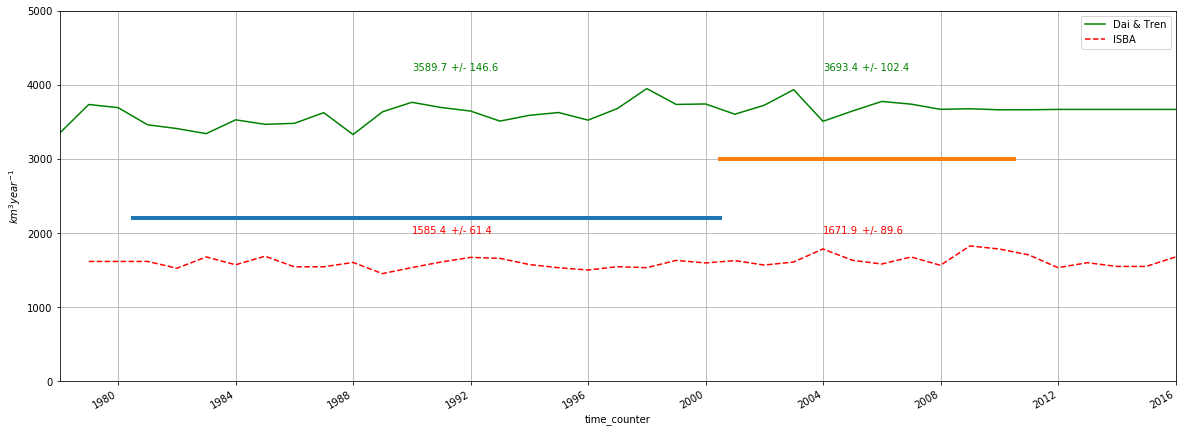

In [33]:
if True: 

    plt.figure(figsize=(20,15))
    ax=plt.subplot(211)
    plt.title('Yearly mean runoffs computed over the Arctic basin')
    (ds_DTBrnf_mon['sorunoff_sum'].resample(time_counter='1Y').mean()*alpha).plot(color='g',label='Dai & Tren')
    (ds_rnf_mon['sorunoff_sum'].resample(time_counter='1Y').mean()*alpha).plot(linestyle='dashed',color='r',label='ISBA')
    plt.ylabel('$km{^3} year^{-1}$')
    plt.xlim(['1978','2016'])
    plt.ylim([0., 5000.])
    plt.grid()

    plt.plot(pd.date_range(start=str(syear_S1),end=str(eyear_S1+1),freq="1Y")+pd.DateOffset(days=-183), np.ones(eyear_S1-syear_S1+1)*2200., linewidth=4, linestyle='solid')
    plt.plot(pd.date_range(start=str(syear_S2),end=str(eyear_S2+1),freq="1Y")+pd.DateOffset(days=-183), np.ones(eyear_S2-syear_S2+1)*3000., linewidth=4, linestyle='solid')


    ax.text('1990', 2000.,str(np.round(np.array(ds_rnf_year['sorunoff_Mean_S1']),decimals=1)), color='r')
    ax.text('1991.5', 2000.,'+/- '+str(np.round(np.array(ds_rnf_year['sorunoff_Std_S1']),decimals=1)), color='r')
    ax.text('2004', 2000.,str(np.round(np.array(ds_rnf_year['sorunoff_Mean_S2']),decimals=1)), color='r')
    ax.text('2005.5', 2000.,'+/- '+str(np.round(np.array(ds_rnf_year['sorunoff_Std_S2']),decimals=1)), color='r')

    ax.text('1990', 4200.,str(np.round(np.array(ds_DTBrnf_year['sorunoff_Mean_S1']),decimals=1)), color='g')
    ax.text('1991.5', 4200.,'+/- '+str(np.round(np.array(ds_DTBrnf_year['sorunoff_Std_S1']),decimals=1)), color='g')
    ax.text('2004', 4200.,str(np.round(np.array(ds_DTBrnf_year['sorunoff_Mean_S2']),decimals=1)), color='g')
    ax.text('2005.5', 4200.,'+/- '+str(np.round(np.array(ds_DTBrnf_year['sorunoff_Std_S2']),decimals=1)), color='g')

    plt.legend()
    savefig=False
    if savefig: plt.savefig('./FIGURES/Runoff_DAI_vs_ISBA_Arctic_Yearly_y19802015.pdf')


> # Read original ISBA data set on a regular 0.5°

In [34]:
DATAIN='/home/datawork-lops-drakkarcom/DATA-REFERENCE/ISBA-FORCING/'

In [35]:
ds_isbaref=xr.open_mfdataset(DATAIN+'sfxcm6_05d_erai_gpcc_daily_rivdis_mouth_????.nc')

In [36]:
ds_isbaref

<xarray.Dataset>
Dimensions:            (bnds: 2, latitude: 360, longitude: 720, time_counter: 14822)
Coordinates:
  * longitude          (longitude) float32 -179.75 -179.25 ... 179.25 179.75
  * latitude           (latitude) float32 -89.75 -89.25 -88.75 ... 89.25 89.75
  * time_counter       (time_counter) datetime64[ns] 1979-01-01T12:00:00 ... 2019-07-31T12:00:00
Dimensions without coordinates: bnds
Data variables:
    time_counter_bnds  (time_counter, bnds) float64 dask.array<shape=(14822, 2), chunksize=(365, 2)>
    rivdis             (time_counter, latitude, longitude) float64 dask.array<shape=(14822, 360, 720), chunksize=(365, 360, 720)>
Attributes:
    CDI:          Climate Data Interface version 1.9.8 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Mon Jun 20 15:11:04 2022: cdo -f nc4 -z zip_1 splityear sfx...
    name:         /scratch/utmp/ftdir/decharme/eclis/transfers/sfxcm6_05d_era...
    description:  Created by xios
    title:        Created by xios


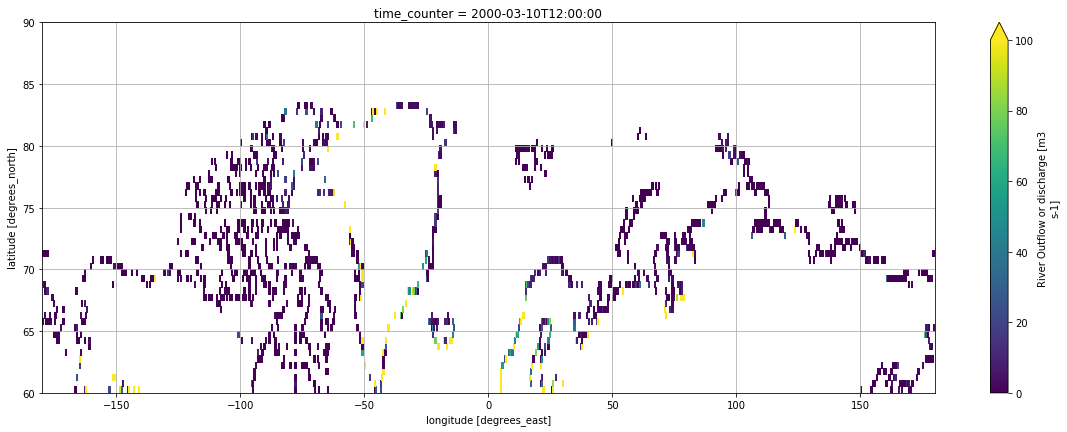

In [37]:
if True: 
    plt.figure(figsize=(20,15))
    plt.subplot(211)
    ds_isbaref['rivdis'].sel(time_counter='2000-03-10',latitude=slice(60,90)).plot(vmax=100.)
    plt.grid(True)

In [56]:
ds_isbaref_Arc=xr.where(ds_isbaref['latitude'] < 65.,0.,ds_isbaref['rivdis'])

In [57]:
ds_isbaref_Arc

<xarray.DataArray (latitude: 360, time_counter: 14822, longitude: 720)>
dask.array<shape=(360, 14822, 720), dtype=float64, chunksize=(360, 365, 720)>
Coordinates:
  * latitude      (latitude) float32 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * longitude     (longitude) float32 -179.75 -179.25 -178.75 ... 179.25 179.75
  * time_counter  (time_counter) datetime64[ns] 1979-01-01T12:00:00 ... 2019-07-31T12:00:00

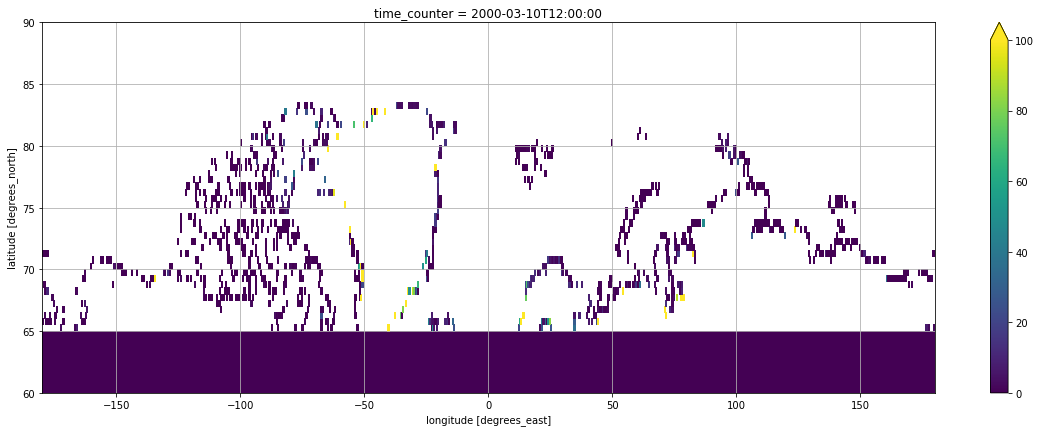

In [58]:
if False: 
    plt.figure(figsize=(20,15))
    plt.subplot(211)
    ds_isbaref_Arc.sel(time_counter='2000-03-10',latitude=slice(60,90)).plot(vmax=100.)
    plt.grid(True)

In [59]:
ds_isbaref_daily=xr.Dataset()
ds_isbaref_daily['runoff_sum']=(('time_counter'),(ds_isbaref_Arc).sum(dim=['latitude','longitude']))
ds_isbaref_daily.coords['time_counter']=(('time_counter'),ds_isbaref_Arc['time_counter'])

In [60]:
ds_isbaref_Arc_mon=xr.Dataset()
ds_isbaref_Arc_mon['runoff_sum']=(('time_counter'),ds_isbaref_daily['runoff_sum'].sel(time_counter=slice('1980-01','2015-12')).resample(time_counter='1M').mean())
ds_isbaref_Arc_mon.coords['time_counter']=(('time_counter'),pd.date_range(start=str(1980)+'-01',end=str(2015)+'-12',freq='MS')+\
                                     pd.DateOffset(days=14))

In [61]:
ds_isbaref_Arc_mon

<xarray.Dataset>
Dimensions:       (time_counter: 432)
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 1980-01-15 ... 2015-12-15
Data variables:
    runoff_sum    (time_counter) float64 3.115e+04 2.667e+04 ... 3.675e+04

In [62]:
ds_isbaref_Arc_year=xr.Dataset()
ds_isbaref_Arc_year['runoff_sum']=(('time_counter'),ds_isbaref_Arc_mon['runoff_sum'].resample(time_counter='1Y').mean())
ds_isbaref_Arc_year.coords['time_counter']=(('time_counter'),pd.date_range(start=str(1980),end=str(2016),freq='1Y')+\
                                     pd.DateOffset(days=-183))

In [63]:
ds_isbaref_Arc_year

<xarray.Dataset>
Dimensions:       (time_counter: 36)
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 1980-07-01 ... 2015-07-01
Data variables:
    runoff_sum    (time_counter) float64 6.516e+04 7.047e+04 ... 7.364e+04

In [46]:
if False: 
    plt.figure(figsize=(20,15))

    plt.subplot(211)
    (ds_isbaref_Arc_mon['runoff_sum']*1e-9*365.*86400.).plot()
    plt.ylabel('$km{^3} year^{-1}$')
    plt.xlim(['1978','2017'])
    plt.ylim([0.,5000.])
    plt.grid(True)

    plt.subplot(212)
    (ds_isbaref_Arc_year['runoff_sum']*1e-9*365.*86400.).plot()
    plt.ylabel('$km{^3} year^{-1}$')
    plt.xlim(['1978','2017'])
    plt.ylim([0.,5000.])
    plt.grid(True)

># Define all area > 65°N

In [47]:
tmsk_ARC=xr.where(ds_dfg['gphit'] < 65., 0., tmask2D)

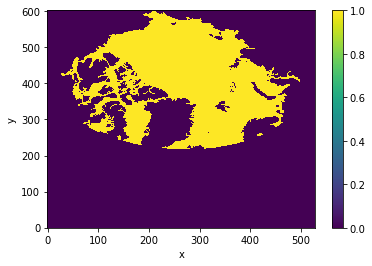

In [48]:
if True: 
    tmsk_ARC.plot()

> # ISBA for lat > 65°N

In [49]:
ds_rnf_daily['sorunoff_sum_Arc']=(('time_counter'),((ds_isbarnf['sorunoff'][:,:,:]*tmsk_ARC[0,:,:]*\
                                                ds_dfg['e1t'].isel(t=0)*\
                                                ds_dfg['e2t'].isel(t=0))*1e-3).sum(dim=['x','y'])*1e-6)

In [50]:
ds_rnf_mon['sorunoff_sum_Arc']=(('time_counter'),ds_rnf_daily['sorunoff_sum_Arc'].resample(time_counter="1M").mean())

In [51]:
ds_rnf_year['sorunoff_sum_Arc']=(('time_counter'),ds_rnf_mon['sorunoff_sum_Arc'].resample(time_counter="1Y").mean())

> # DTB for lat > 65°N

In [52]:
ds_DTBrnf_mon['sorunoff_sum_Arc']=(('time_counter'),((ds_DTBrnf['runoff'][:,:,:]*tmsk_ARC[0,:,:]*\
                                                ds_dfg['e1t'].isel(t=0)*\
                                                ds_dfg['e2t'].isel(t=0))*1e-3).sum(dim=['x','y'])*1e-6)

In [53]:
ds_DTBrnf_year['sorunoff_sum_Arc']=(('time_counter'),ds_DTBrnf_mon['sorunoff_sum_Arc'].resample(time_counter="1Y").mean())

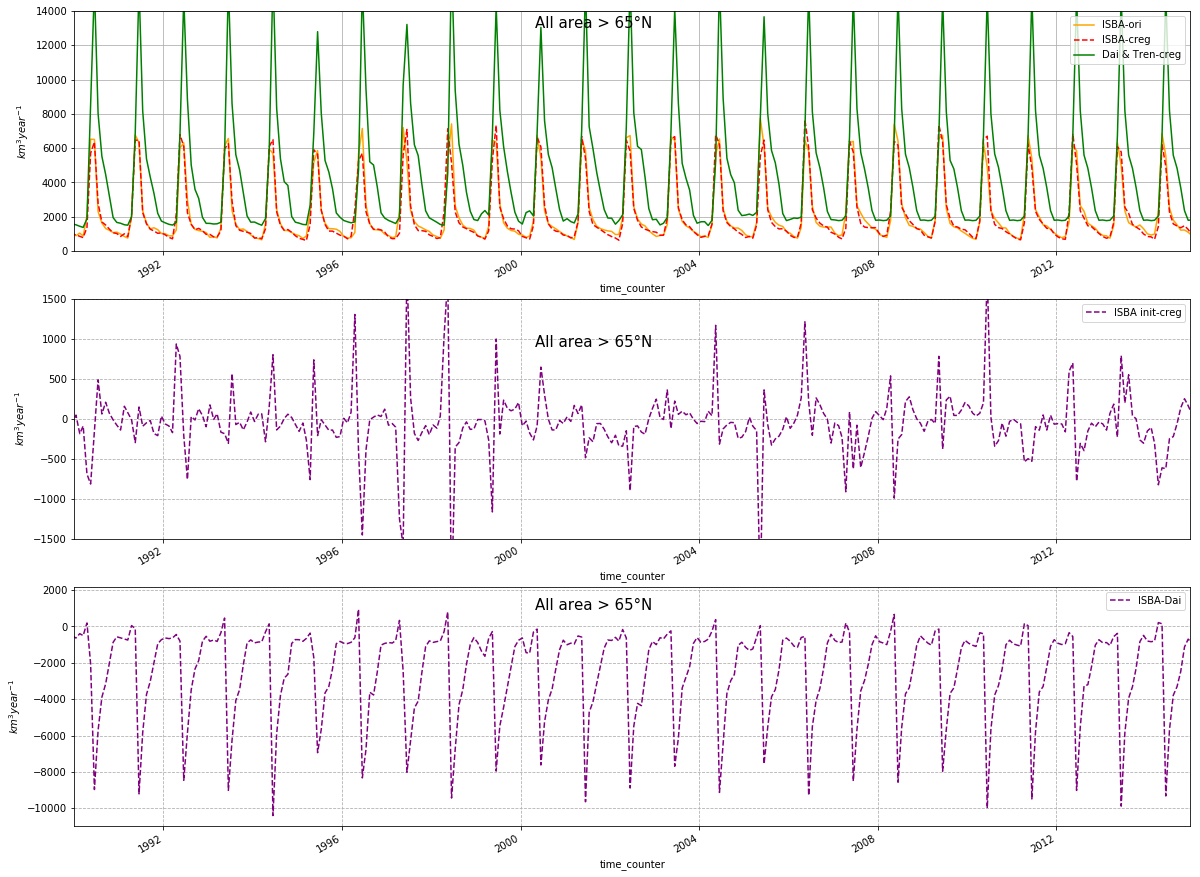

In [84]:
plt.figure(figsize=(20,15))

plt.subplot(311)
(ds_isbaref_Arc_mon['runoff_sum']*1e-9*365.*86400.).plot(color='orange',label='ISBA-ori')
(ds_rnf_mon['sorunoff_sum_Arc']*alpha).plot(color='r',linestyle='dashed',label='ISBA-creg')
(ds_DTBrnf_mon['sorunoff_sum_Arc']*alpha).plot(color='g',label='Dai & Tren-creg')
plt.text('2000.5',13000.,'All area > 65°N', size=15)
plt.ylabel('$km{^3} year^{-1}$')
plt.xlim(['1990','2015'])
plt.ylim([0., 14000.])
plt.grid(True)
plt.legend()

plt.subplot(312)
(ds_rnf_mon['sorunoff_sum_Arc']*alpha-ds_isbaref_Arc_mon['runoff_sum']*1e-9*365.*86400.).plot\
(color='purple',linestyle='dashed',label='ISBA init-creg')
plt.text('2000.5',900.,'All area > 65°N', size=15)
plt.ylabel('$km{^3} year^{-1}$')
plt.xlim(['1990','2015'])
plt.ylim([-1500., 1500.])
plt.grid(True,linestyle='dashed')
plt.legend()

plt.subplot(313)
(ds_isbaref_Arc_mon['runoff_sum']*1e-9*365.*86400.-ds_DTBrnf_mon['sorunoff_sum_Arc']*alpha).plot\
(color='purple',linestyle='dashed',label='ISBA-Dai')
plt.text('2000.5',900.,'All area > 65°N', size=15)
plt.ylabel('$km{^3} year^{-1}$')
plt.xlim(['1990','2015'])
#plt.ylim([-6000., 6000.])
plt.grid(True,linestyle='dashed')
plt.legend()

savefig=False
if savefig: plt.savefig('./FIGURES/Runoff_DAI_vs_ISBA_ArcticG65DegN_Monthly_y19902015.pdf')

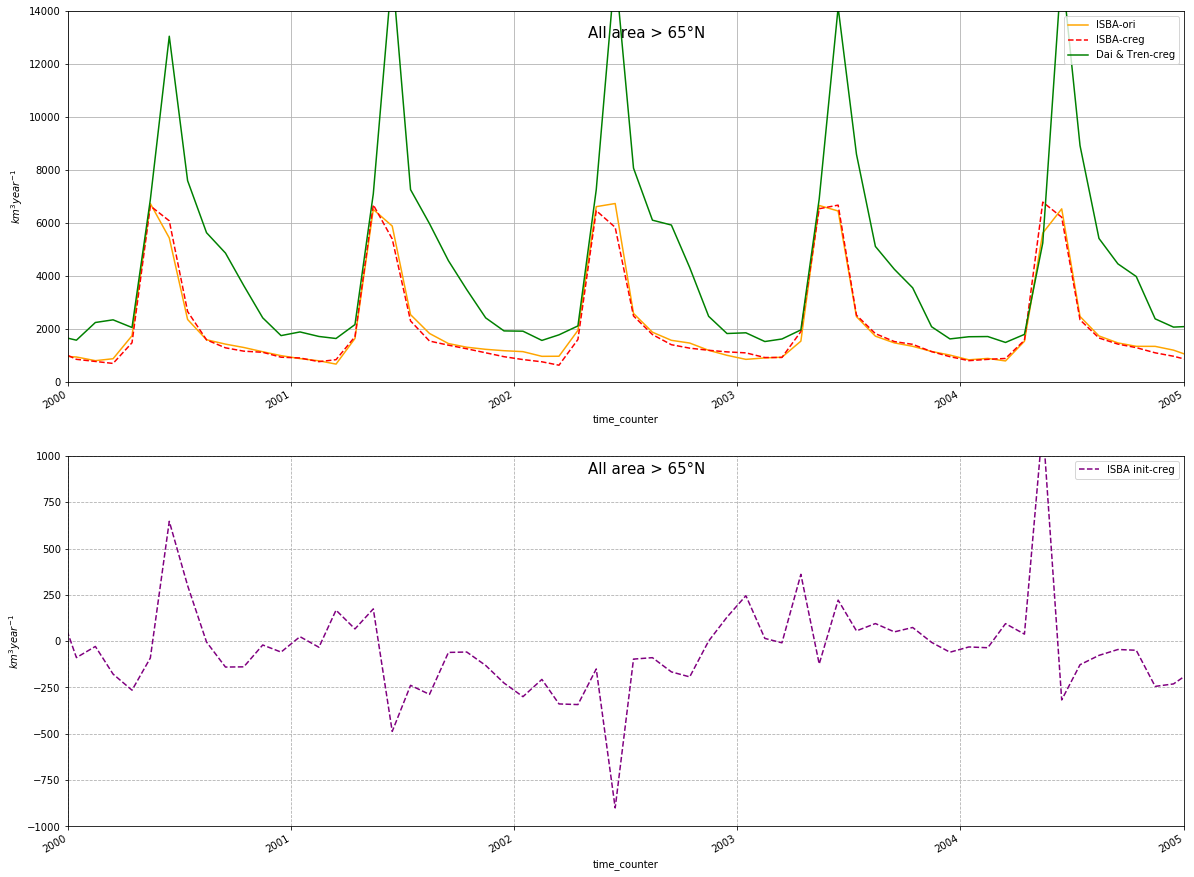

In [65]:
if True: 
    plt.figure(figsize=(20,15))

    plt.subplot(211)
    (ds_isbaref_Arc_mon['runoff_sum']*1e-9*365.*86400.).plot(color='orange',label='ISBA-ori')
    (ds_rnf_mon['sorunoff_sum_Arc']*alpha).plot(color='r',linestyle='dashed',label='ISBA-creg')
    (ds_DTBrnf_mon['sorunoff_sum_Arc']*alpha).plot(color='g',label='Dai & Tren-creg')
    plt.text('2002.5',13000.,'All area > 65°N', size=15)
    plt.ylabel('$km{^3} year^{-1}$')
    plt.xlim(['2000','2005'])
    plt.ylim([0., 14000.])
    plt.grid(True)
    plt.legend()

    plt.subplot(212)
    (ds_rnf_mon['sorunoff_sum_Arc']*alpha-ds_isbaref_Arc_mon['runoff_sum']*1e-9*365.*86400.).plot\
    (color='purple',linestyle='dashed',label='ISBA init-creg')
    plt.text('2002.5',900.,'All area > 65°N', size=15)
    plt.ylabel('$km{^3} year^{-1}$')
    plt.xlim(['2000','2005'])
    plt.ylim([-1000., 1000.])
    plt.grid(True,linestyle='dashed')
    plt.legend()

    savefig=False
    if savefig: plt.savefig('./FIGURES/Runoff_DAI_vs_ISBA_ArcticG65DegN_Monthly_y20002005.pdf')

> # Define a box over the Eurasian basin only 

In [55]:
tmsk_ARC_EURA=xr.where((ds_dfg['gphit'] <  65.), 0., tmask2D)
tmsk_ARC_EURA=xr.where((ds_dfg['gphit'] >  80.), 0., tmsk_ARC_EURA)
tmsk_ARC_EURA=xr.where((ds_dfg['glamt'] <  90.), 0., tmsk_ARC_EURA) 
tmsk_ARC_EURA=xr.where((ds_dfg['glamt'] > 180.), 0., tmsk_ARC_EURA) 

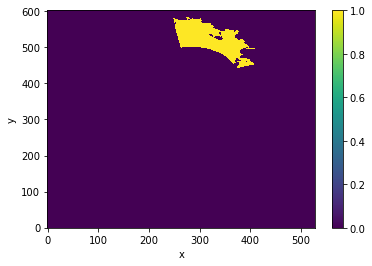

In [56]:
if False: 
    tmsk_ARC_EURA.plot()

# > ISBA original data over the Eurasian box

In [67]:
ds_isbaref_Arc_Eura=xr.where(ds_isbaref['latitude']   < 65.,0.,ds_isbaref['rivdis'])
ds_isbaref_Arc_Eura=xr.where(ds_isbaref['latitude']   > 80.,0.,ds_isbaref_Arc_Eura)
ds_isbaref_Arc_Eura=xr.where(ds_isbaref['longitude'] <  90.,0.,ds_isbaref_Arc_Eura)
ds_isbaref_Arc_Eura=xr.where(ds_isbaref['longitude'] > 180.,0.,ds_isbaref_Arc_Eura)

In [68]:
ds_isbaref_Arc_Eura

<xarray.DataArray (longitude: 720, latitude: 360, time_counter: 14822)>
dask.array<shape=(720, 360, 14822), dtype=float64, chunksize=(720, 360, 365)>
Coordinates:
  * longitude     (longitude) float32 -179.75 -179.25 -178.75 ... 179.25 179.75
  * latitude      (latitude) float32 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * time_counter  (time_counter) datetime64[ns] 1979-01-01T12:00:00 ... 2019-07-31T12:00:00

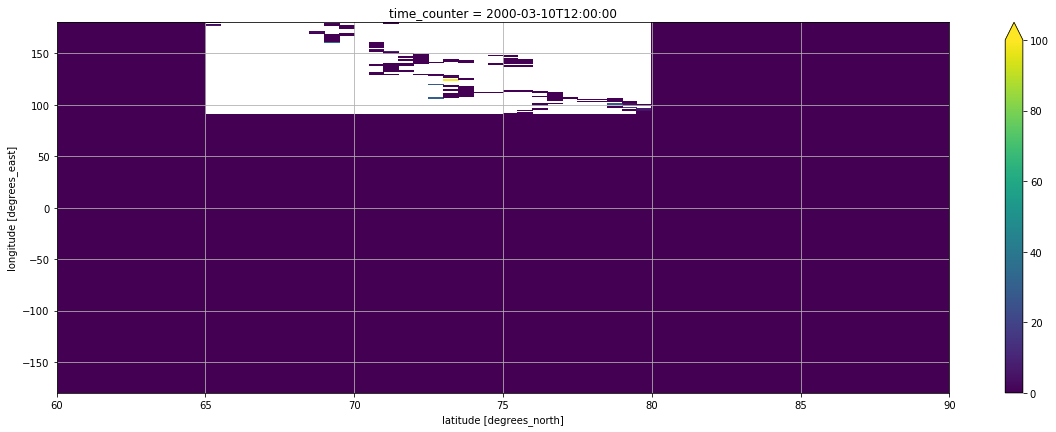

In [85]:
plt.figure(figsize=(20,15))
plt.subplot(211)
ds_isbaref_Arc_Eura.sel(time_counter='2000-03-10',latitude=slice(60,90)).plot(vmax=100.)
plt.grid(True)

In [59]:
ds_isbaref_daily['runoff_sum_Eura']=(('time_counter'),(ds_isbaref_Arc_Eura).sum(dim=['latitude','longitude']))
ds_isbaref_Arc_mon['runoff_sum_Eura']=(('time_counter'),ds_isbaref_daily['runoff_sum_Eura'].sel(time_counter=slice('1980-01','2015-12')).resample(time_counter='1M').mean())
ds_isbaref_Arc_year['runoff_sum_Eura']=(('time_counter'),ds_isbaref_Arc_mon['runoff_sum_Eura'].resample(time_counter='1Y').mean())

# > ISBA data over the Eurasian box

In [60]:
ds_rnf_daily['sorunoff_sum_Eura']=(('time_counter'),((ds_isbarnf['sorunoff'][:,:,:]*tmsk_ARC_EURA[0,:,:]*\
                                                ds_dfg['e1t'].isel(t=0)*\
                                                ds_dfg['e2t'].isel(t=0))*1e-3).sum(dim=['x','y'])*1e-6)

In [61]:
ds_rnf_mon['sorunoff_sum_Eura']=(('time_counter'),ds_rnf_daily['sorunoff_sum_Eura'].resample(time_counter="1M").mean())

In [62]:
ds_rnf_year['sorunoff_sum_Eura']=(('time_counter'),ds_rnf_mon['sorunoff_sum_Eura'].resample(time_counter="1Y").mean())

# > Dai data over the Eurasian box

In [63]:
ds_DTBrnf_mon['sorunoff_sum_Eura']=(('time_counter'),((ds_DTBrnf['runoff'][:,:,:]*tmsk_ARC_EURA[0,:,:]*\
                                                ds_dfg['e1t'].isel(t=0)*\
                                                ds_dfg['e2t'].isel(t=0))*1e-3).sum(dim=['x','y'])*1e-6)

In [64]:
ds_DTBrnf_year['sorunoff_sum_Eura']=(('time_counter'),ds_DTBrnf_mon['sorunoff_sum_Eura'].resample(time_counter="1Y").mean())

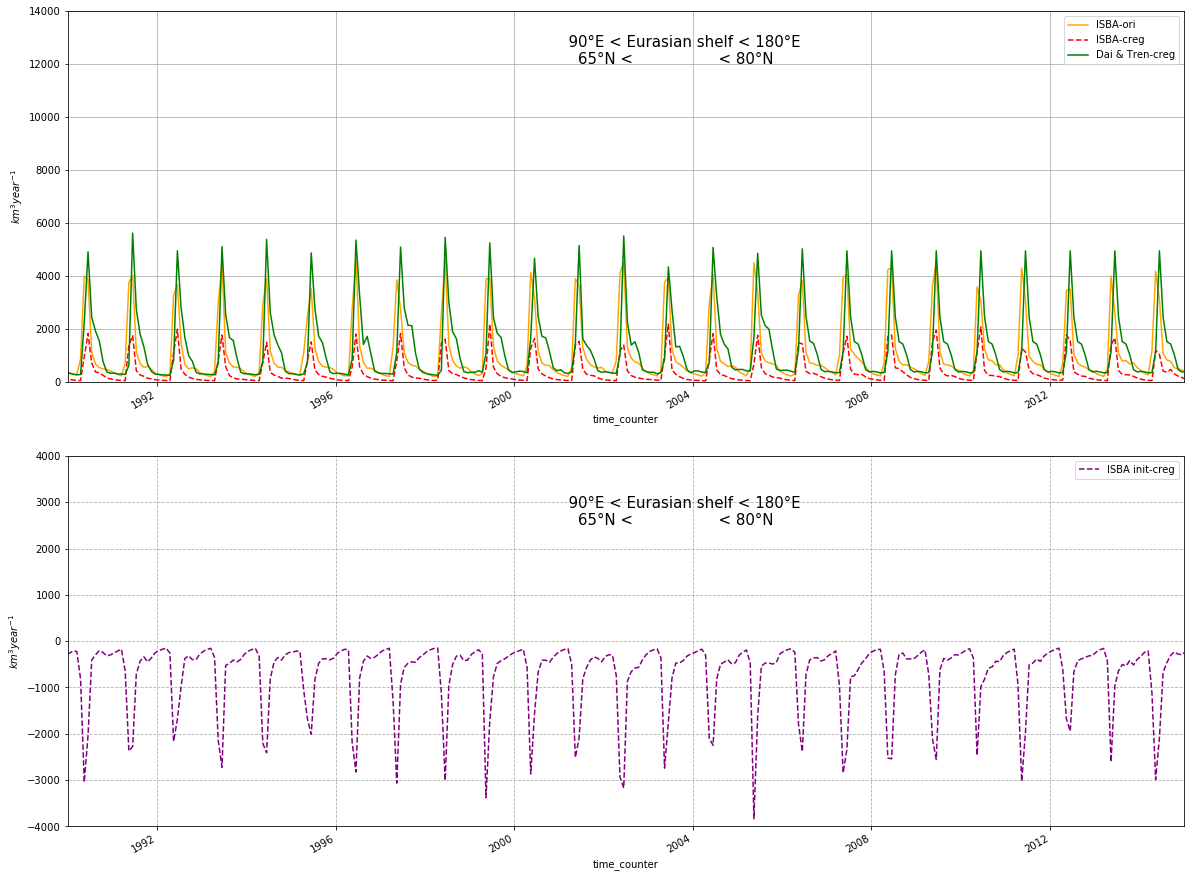

In [98]:
if False: 
    plt.figure(figsize=(20,15))

    plt.subplot(211)
    (ds_isbaref_Arc_mon['runoff_sum_Eura']*1e-9*365.*86400.).plot(color='orange',label='ISBA-ori')
    (ds_rnf_mon['sorunoff_sum_Eura']*alpha).plot(color='r',linestyle='dashed',label='ISBA-creg')
    (ds_DTBrnf_mon['sorunoff_sum_Eura']*alpha).plot(color='g',label='Dai & Tren-creg')
    plt.text('2001.',12000.,'  90°E < Eurasian shelf < 180°E \n    65°N <                  < 80°N', size=15)
    plt.ylabel('$km{^3} year^{-1}$')
    plt.xlim(['1990','2015'])
    plt.ylim([0., 14000.])
    plt.grid(True)
    plt.legend()

    plt.subplot(212)
    (ds_rnf_mon['sorunoff_sum_Eura']*alpha-ds_isbaref_Arc_mon['runoff_sum_Eura']*1e-9*365.*86400.).plot\
    (color='purple',linestyle='dashed',label='ISBA init-creg')
    plt.text('2001.',2500.,'  90°E < Eurasian shelf < 180°E \n    65°N <                  < 80°N', size=15)
    plt.ylabel('$km{^3} year^{-1}$')
    plt.xlim(['1990','2015'])
    plt.ylim([-4000., 4000.])
    plt.grid(True,linestyle='dashed')
    plt.legend()

    savefig=True
    if savefig: plt.savefig('./FIGURES/Runoff_DAI_vs_ISBA_Eura65N-80N-90E-180E_Monthly_y19902015.pdf')

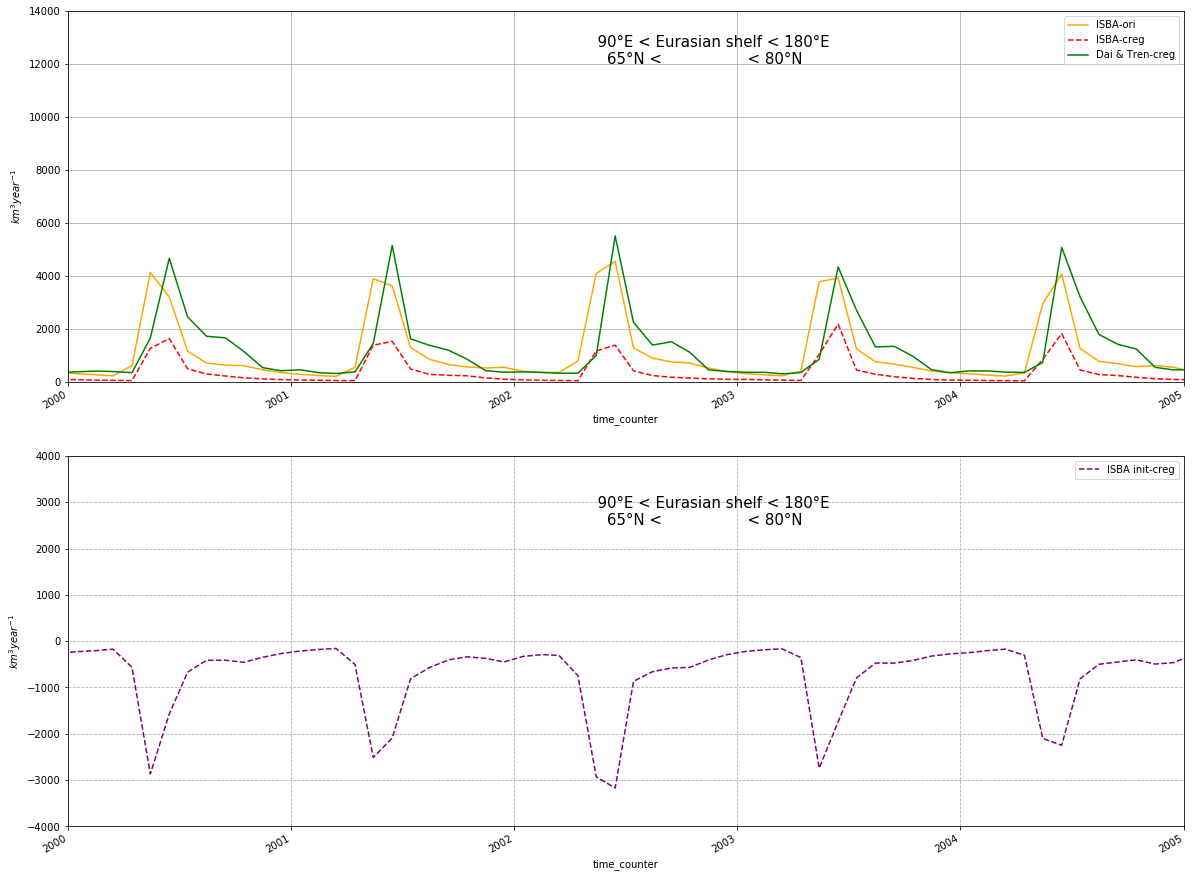

In [99]:
if False: 
    plt.figure(figsize=(20,15))

    plt.subplot(211)
    (ds_isbaref_Arc_mon['runoff_sum_Eura']*1e-9*365.*86400.).plot(color='orange',label='ISBA-ori')
    (ds_rnf_mon['sorunoff_sum_Eura']*alpha).plot(color='r',linestyle='dashed',label='ISBA-creg')
    (ds_DTBrnf_mon['sorunoff_sum_Eura']*alpha).plot(color='g',label='Dai & Tren-creg')
    plt.text('2002.5',12000.,'  90°E < Eurasian shelf < 180°E \n    65°N <                  < 80°N', size=15)
    plt.ylabel('$km{^3} year^{-1}$')
    plt.xlim(['2000','2005'])
    plt.ylim([0., 14000.])
    plt.grid(True)
    plt.legend()


    plt.subplot(212)
    (ds_rnf_mon['sorunoff_sum_Eura']*alpha-ds_isbaref_Arc_mon['runoff_sum_Eura']*1e-9*365.*86400.).plot\
    (color='purple',linestyle='dashed',label='ISBA init-creg')
    plt.text('2002.5',2500.,'  90°E < Eurasian shelf < 180°E \n    65°N <                  < 80°N', size=15)
    plt.ylabel('$km{^3} year^{-1}$')
    plt.xlim(['2000','2005'])
    plt.ylim([-4000., 4000.])
    plt.grid(True,linestyle='dashed')
    plt.legend()


    savefig=False
    if savefig: plt.savefig('./FIGURES/Runoff_DAI_vs_ISBA_Eura65N-80N-90E-180E_Monthly_y20002005.pdf')

> # ISBA original data over Barents & Kara areas

In [56]:
ds_isbaref_Arc_Baka=xr.where(ds_isbaref['latitude']   < 65.,0.,ds_isbaref['rivdis'])
ds_isbaref_Arc_Baka=xr.where(ds_isbaref['latitude']   > 80.,0.,ds_isbaref_Arc_Baka)
ds_isbaref_Arc_Baka=xr.where(ds_isbaref['longitude'] <   0.,0.,ds_isbaref_Arc_Baka)
ds_isbaref_Arc_Baka=xr.where(ds_isbaref['longitude'] >  90.,0.,ds_isbaref_Arc_Baka)

In [57]:
ds_isbaref_Arc_Baka

<xarray.DataArray (longitude: 720, latitude: 360, time_counter: 14822)>
dask.array<shape=(720, 360, 14822), dtype=float64, chunksize=(720, 360, 365)>
Coordinates:
  * longitude     (longitude) float32 -179.75 -179.25 -178.75 ... 179.25 179.75
  * latitude      (latitude) float32 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * time_counter  (time_counter) datetime64[ns] 1979-01-01T12:00:00 ... 2019-07-31T12:00:00

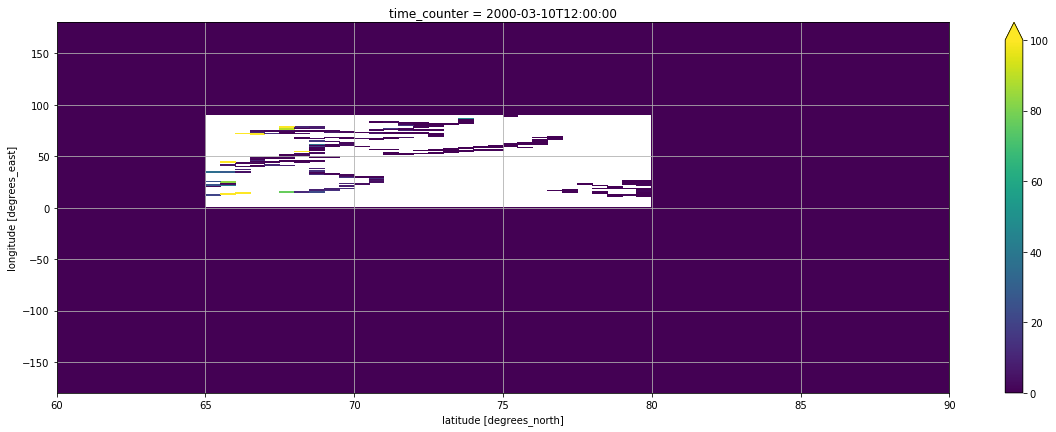

In [59]:
if True: 
    plt.figure(figsize=(20,15))
    plt.subplot(211)
    ds_isbaref_Arc_Baka.sel(time_counter='2000-03-10',latitude=slice(60,90)).plot(vmax=100.)
    plt.grid(True)

In [60]:
ds_isbaref_daily['runoff_sum_Baka']=(('time_counter'),(ds_isbaref_Arc_Baka).sum(dim=['latitude','longitude']))
ds_isbaref_Arc_mon['runoff_sum_Baka']=(('time_counter'),ds_isbaref_daily['runoff_sum_Baka'].sel(time_counter=slice('1980-01','2015-12')).resample(time_counter='1M').mean())
ds_isbaref_Arc_year['runoff_sum_Baka']=(('time_counter'),ds_isbaref_Arc_mon['runoff_sum_Baka'].resample(time_counter='1Y').mean())

In [61]:
ds_isbaref_Arc_mon

<xarray.Dataset>
Dimensions:          (time_counter: 432)
Coordinates:
  * time_counter     (time_counter) datetime64[ns] 1980-01-15 ... 2015-12-15
Data variables:
    runoff_sum       (time_counter) float64 9.285e+03 8.002e+03 ... 1.094e+04
    runoff_sum_Grca  (time_counter) float64 1.032e+04 1.019e+04 ... 1.145e+04
    runoff_sum_Baka  (time_counter) float64 1.547e+04 1.147e+04 ... 1.94e+04

> # Define a box over the Barents & Kara areas 

In [62]:
tmsk_ARC_BAKA=xr.where((ds_dfg['gphit'] <  65.), 0., tmask2D)
tmsk_ARC_BAKA=xr.where((ds_dfg['gphit'] >  80.), 0., tmsk_ARC_BAKA)
tmsk_ARC_BAKA=xr.where((ds_dfg['glamt'] <   0.), 0., tmsk_ARC_BAKA) 
tmsk_ARC_BAKA=xr.where((ds_dfg['glamt'] >  90.), 0., tmsk_ARC_BAKA) 

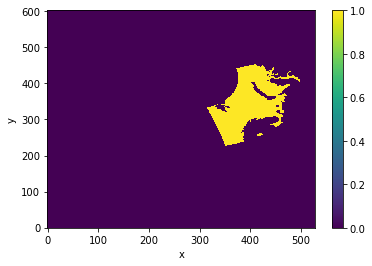

In [64]:
if True: 
    tmsk_ARC_BAKA.plot()

# > ISBA data over the Barents & Kara areas

In [65]:
ds_rnf_daily['sorunoff_sum_Baka']=(('time_counter'),((ds_isbarnf['sorunoff'][:,:,:]*tmsk_ARC_BAKA[0,:,:]*\
                                                ds_dfg['e1t'].isel(t=0)*\
                                                ds_dfg['e2t'].isel(t=0))*1e-3).sum(dim=['x','y'])*1e-6)

ds_rnf_mon['sorunoff_sum_Baka']=(('time_counter'),ds_rnf_daily['sorunoff_sum_Baka'].resample(time_counter="1M").mean())

ds_rnf_year['sorunoff_sum_Baka']=(('time_counter'),ds_rnf_mon['sorunoff_sum_Baka'].resample(time_counter="1Y").mean())

# > Dai data over the Barents & Kara areas

In [66]:
ds_DTBrnf_mon['sorunoff_sum_Baka']=(('time_counter'),((ds_DTBrnf['runoff'][:,:,:]*tmsk_ARC_BAKA[0,:,:]*\
                                                ds_dfg['e1t'].isel(t=0)*\
                                                ds_dfg['e2t'].isel(t=0))*1e-3).sum(dim=['x','y'])*1e-6)

ds_DTBrnf_year['sorunoff_sum_Baka']=(('time_counter'),ds_DTBrnf_mon['sorunoff_sum_Baka'].resample(time_counter="1Y").mean())

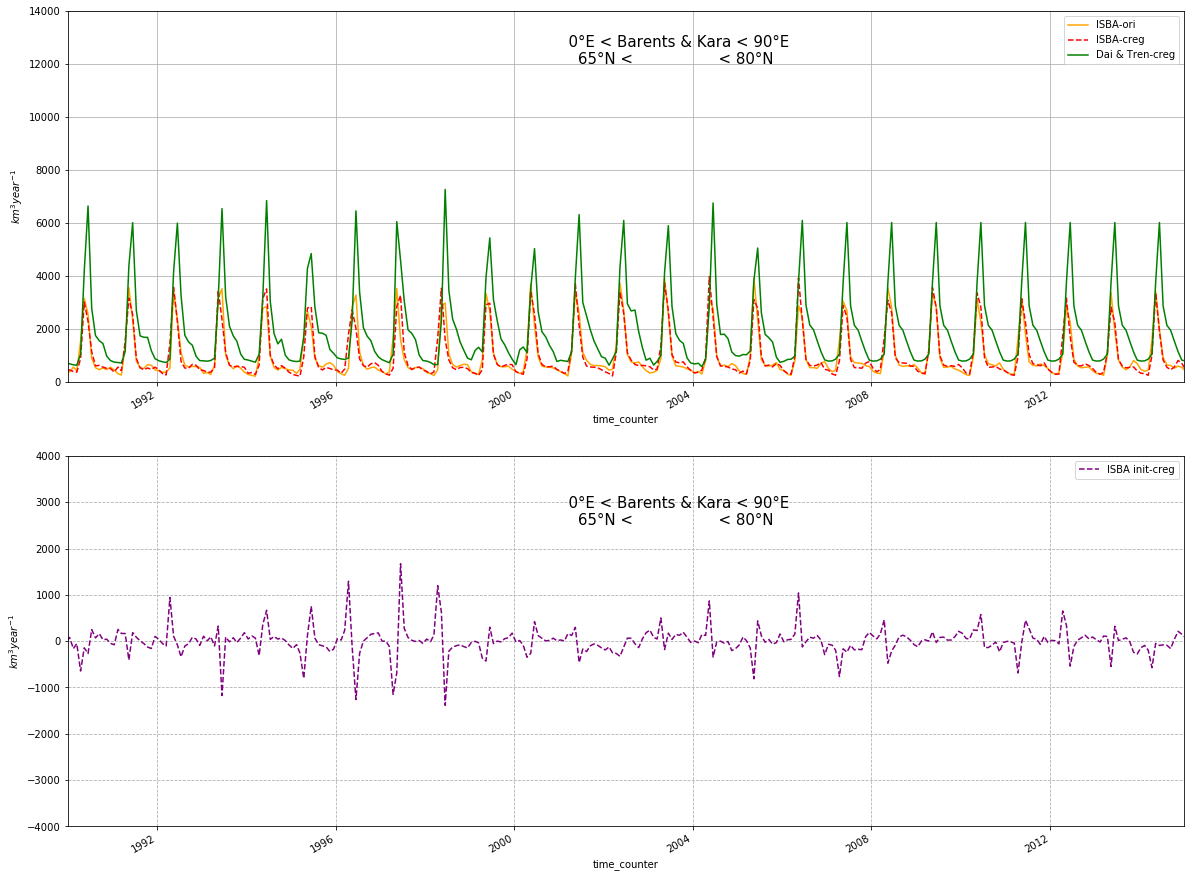

In [110]:
if False: 
    plt.figure(figsize=(20,15))

    plt.subplot(211)
    (ds_isbaref_Arc_mon['runoff_sum_Baka']*1e-9*365.*86400.).plot(color='orange',label='ISBA-ori')
    (ds_rnf_mon['sorunoff_sum_Baka']*alpha).plot(color='r',linestyle='dashed',label='ISBA-creg')
    (ds_DTBrnf_mon['sorunoff_sum_Baka']*alpha).plot(color='g',label='Dai & Tren-creg')
    plt.text('2001.',12000.,'  0°E < Barents & Kara < 90°E \n    65°N <                  < 80°N', size=15)
    plt.ylabel('$km{^3} year^{-1}$')
    plt.xlim(['1990','2015'])
    plt.ylim([0., 14000.])
    plt.grid(True)
    plt.legend()

    plt.subplot(212)
    (ds_rnf_mon['sorunoff_sum_Baka']*alpha-ds_isbaref_Arc_mon['runoff_sum_Baka']*1e-9*365.*86400.).plot\
    (color='purple',linestyle='dashed',label='ISBA init-creg')
    plt.text('2001.',2500.,'  0°E < Barents & Kara < 90°E \n    65°N <                  < 80°N', size=15)
    plt.ylabel('$km{^3} year^{-1}$')
    plt.xlim(['1990','2015'])
    plt.ylim([-4000., 4000.])
    plt.grid(True,linestyle='dashed')
    plt.legend()

    savefig=True
    if savefig: plt.savefig('./FIGURES/Runoff_DAI_vs_ISBA_BarentsKara65N-80N-0E-90E_Monthly_y19902015.pdf')

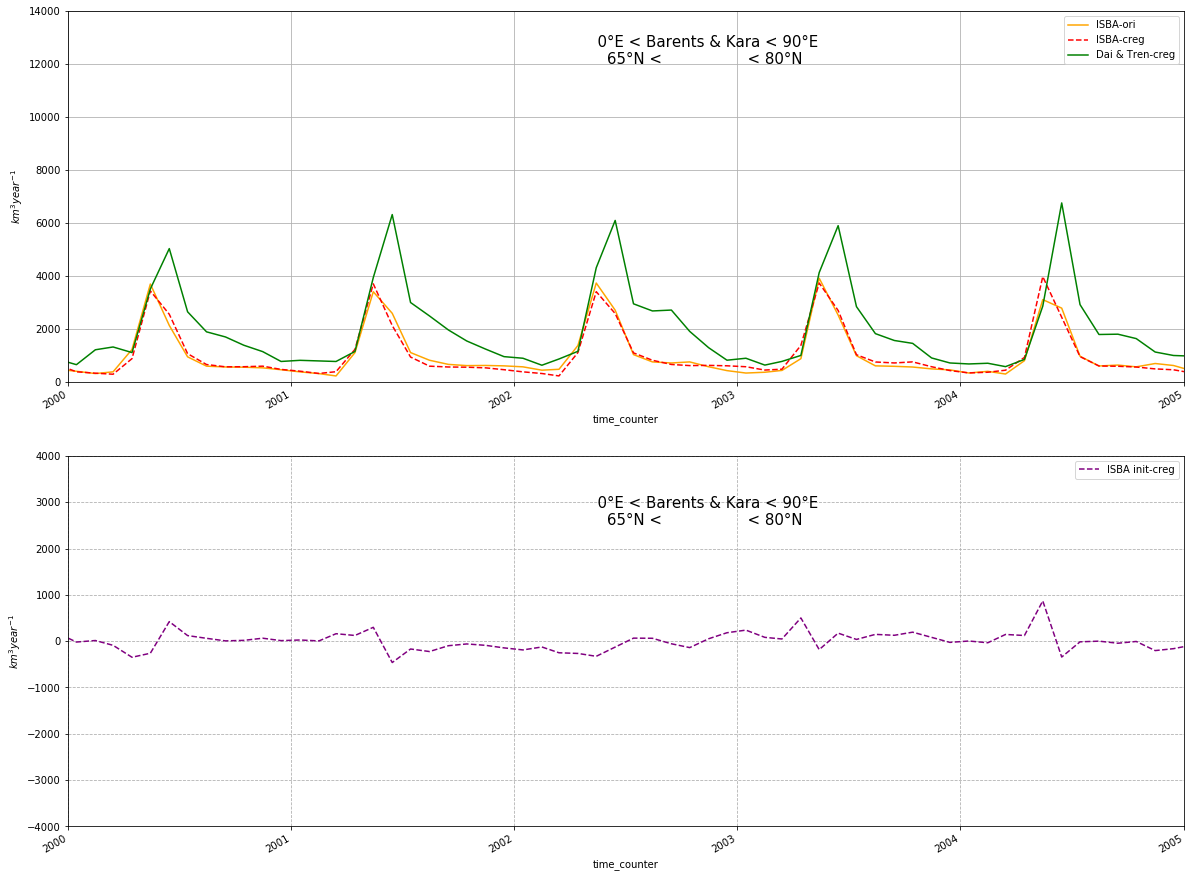

In [67]:
if False: 
    plt.figure(figsize=(20,15))

    plt.subplot(211)
    (ds_isbaref_Arc_mon['runoff_sum_Baka']*1e-9*365.*86400.).plot(color='orange',label='ISBA-ori')
    (ds_rnf_mon['sorunoff_sum_Baka']*alpha).plot(color='r',linestyle='dashed',label='ISBA-creg')
    (ds_DTBrnf_mon['sorunoff_sum_Baka']*alpha).plot(color='g',label='Dai & Tren-creg')
    plt.text('2002.5',12000.,'  0°E < Barents & Kara < 90°E \n    65°N <                  < 80°N', size=15)
    plt.ylabel('$km{^3} year^{-1}$')
    plt.xlim(['2000','2005'])
    plt.ylim([0., 14000.])
    plt.grid(True)
    plt.legend()


    plt.subplot(212)
    (ds_rnf_mon['sorunoff_sum_Baka']*alpha-ds_isbaref_Arc_mon['runoff_sum_Baka']*1e-9*365.*86400.).plot\
    (color='purple',linestyle='dashed',label='ISBA init-creg')
    plt.text('2002.5',2500.,'  0°E < Barents & Kara < 90°E \n    65°N <                  < 80°N', size=15)
    plt.ylabel('$km{^3} year^{-1}$')
    plt.xlim(['2000','2005'])
    plt.ylim([-4000., 4000.])
    plt.grid(True,linestyle='dashed')
    plt.legend()


    savefig=True
    if savefig: plt.savefig('./FIGURES/Runoff_DAI_vs_ISBA_BarentsKara65N-80N-0E-90E_Monthly_y20002005.pdf')

> # ISBA original data over Greenland & CAA areas

In [46]:
ds_isbaref_Arc_Grca=xr.where(ds_isbaref['latitude']   < 65.,0.,ds_isbaref['rivdis'])
ds_isbaref_Arc_Grca=xr.where(ds_isbaref['latitude']   > 80.,0.,ds_isbaref_Arc_Grca)
ds_isbaref_Arc_Grca=xr.where(ds_isbaref['longitude'] < -120.,0.,ds_isbaref_Arc_Grca)
ds_isbaref_Arc_Grca=xr.where(ds_isbaref['longitude'] >    0.,0.,ds_isbaref_Arc_Grca)

In [47]:
ds_isbaref_Arc_Grca

<xarray.DataArray (longitude: 720, latitude: 360, time_counter: 14822)>
dask.array<shape=(720, 360, 14822), dtype=float64, chunksize=(720, 360, 365)>
Coordinates:
  * longitude     (longitude) float32 -179.75 -179.25 -178.75 ... 179.25 179.75
  * latitude      (latitude) float32 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * time_counter  (time_counter) datetime64[ns] 1979-01-01T12:00:00 ... 2019-07-31T12:00:00

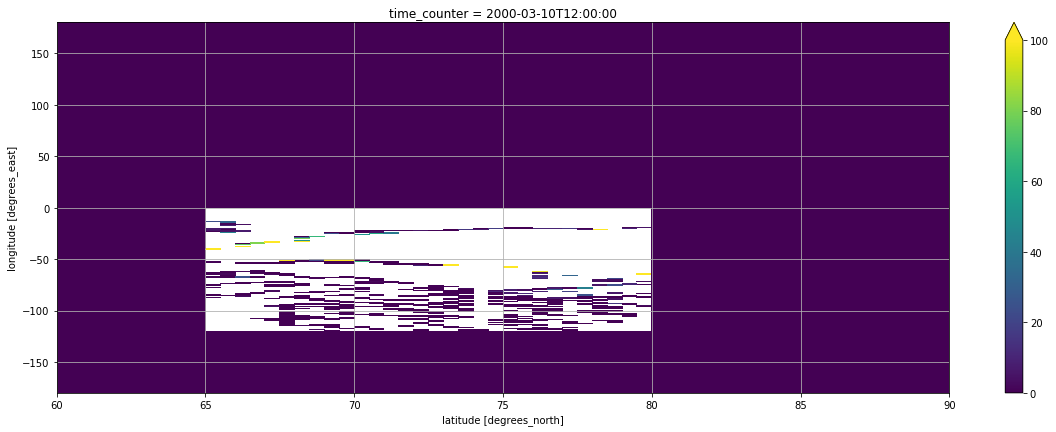

In [48]:
plt.figure(figsize=(20,15))
plt.subplot(211)
ds_isbaref_Arc_Grca.sel(time_counter='2000-03-10',latitude=slice(60,90)).plot(vmax=100.)
plt.grid(True)

In [49]:
ds_isbaref_daily['runoff_sum_Grca']=(('time_counter'),(ds_isbaref_Arc_Grca).sum(dim=['latitude','longitude']))
ds_isbaref_Arc_mon['runoff_sum_Grca']=(('time_counter'),ds_isbaref_daily['runoff_sum_Grca'].sel(time_counter=slice('1980-01','2015-12')).resample(time_counter='1M').mean())
ds_isbaref_Arc_year['runoff_sum_Grca']=(('time_counter'),ds_isbaref_Arc_mon['runoff_sum_Grca'].resample(time_counter='1Y').mean())

> # Define a box over the Greenland & CAA areas 

In [50]:
tmsk_ARC_GRCA=xr.where((ds_dfg['gphit'] <  65.), 0., tmask2D)
tmsk_ARC_GRCA=xr.where((ds_dfg['gphit'] >  80.), 0., tmsk_ARC_GRCA)
tmsk_ARC_GRCA=xr.where((ds_dfg['glamt'] < -120.), 0., tmsk_ARC_GRCA) 
tmsk_ARC_GRCA=xr.where((ds_dfg['glamt'] >    0.), 0., tmsk_ARC_GRCA) 

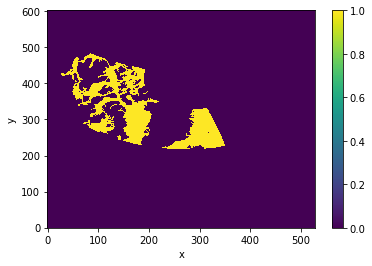

In [51]:
tmsk_ARC_GRCA.plot()

# > ISBA data over the Greenland & CAA areas

In [52]:
ds_rnf_daily['sorunoff_sum_Grca']=(('time_counter'),((ds_isbarnf['sorunoff'][:,:,:]*tmsk_ARC_GRCA[0,:,:]*\
                                                ds_dfg['e1t'].isel(t=0)*\
                                                ds_dfg['e2t'].isel(t=0))*1e-3).sum(dim=['x','y'])*1e-6)

ds_rnf_mon['sorunoff_sum_Grca']=(('time_counter'),ds_rnf_daily['sorunoff_sum_Grca'].resample(time_counter="1M").mean())

ds_rnf_year['sorunoff_sum_Grca']=(('time_counter'),ds_rnf_mon['sorunoff_sum_Grca'].resample(time_counter="1Y").mean())

# > Dai data over the Greenland & CAA areas

In [53]:
ds_DTBrnf_mon['sorunoff_sum_Grca']=(('time_counter'),((ds_DTBrnf['runoff'][:,:,:]*tmsk_ARC_GRCA[0,:,:]*\
                                                ds_dfg['e1t'].isel(t=0)*\
                                                ds_dfg['e2t'].isel(t=0))*1e-3).sum(dim=['x','y'])*1e-6)

ds_DTBrnf_year['sorunoff_sum_Grca']=(('time_counter'),ds_DTBrnf_mon['sorunoff_sum_Grca'].resample(time_counter="1Y").mean())

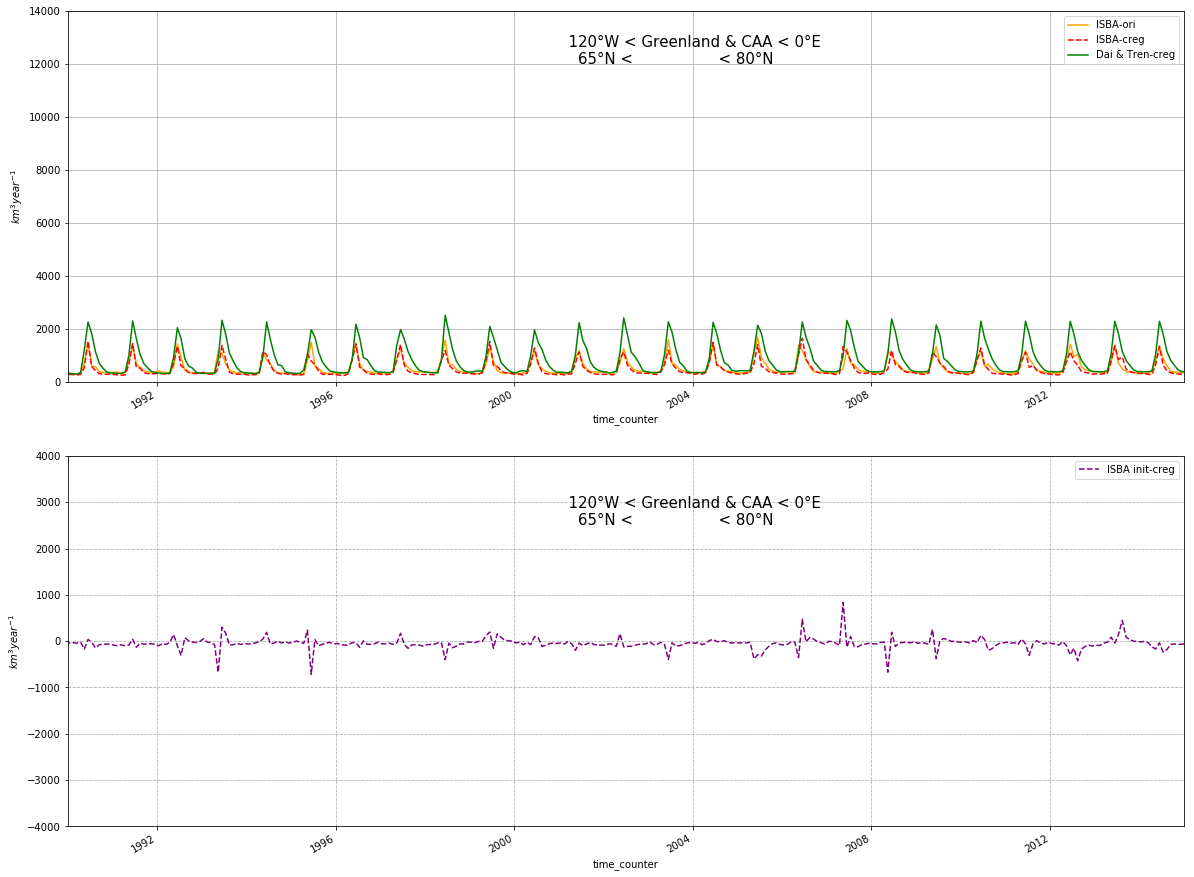

In [54]:
plt.figure(figsize=(20,15))

plt.subplot(211)
(ds_isbaref_Arc_mon['runoff_sum_Grca']*1e-9*365.*86400.).plot(color='orange',label='ISBA-ori')
(ds_rnf_mon['sorunoff_sum_Grca']*alpha).plot(color='r',linestyle='dashed',label='ISBA-creg')
(ds_DTBrnf_mon['sorunoff_sum_Grca']*alpha).plot(color='g',label='Dai & Tren-creg')
plt.text('2001.',12000.,'  120°W < Greenland & CAA < 0°E \n    65°N <                  < 80°N', size=15)
plt.ylabel('$km{^3} year^{-1}$')
plt.xlim(['1990','2015'])
plt.ylim([0., 14000.])
plt.grid(True)
plt.legend()

plt.subplot(212)
(ds_rnf_mon['sorunoff_sum_Grca']*alpha-ds_isbaref_Arc_mon['runoff_sum_Grca']*1e-9*365.*86400.).plot\
(color='purple',linestyle='dashed',label='ISBA init-creg')
plt.text('2001.',2500.,'  120°W < Greenland & CAA < 0°E \n    65°N <                  < 80°N', size=15)
plt.ylabel('$km{^3} year^{-1}$')
plt.xlim(['1990','2015'])
plt.ylim([-4000., 4000.])
plt.grid(True,linestyle='dashed')
plt.legend()

savefig=False
if savefig: plt.savefig('./FIGURES/Runoff_DAI_vs_ISBA_GreenlandCAA65N-80N-0E-120W_Monthly_y19902015.pdf')

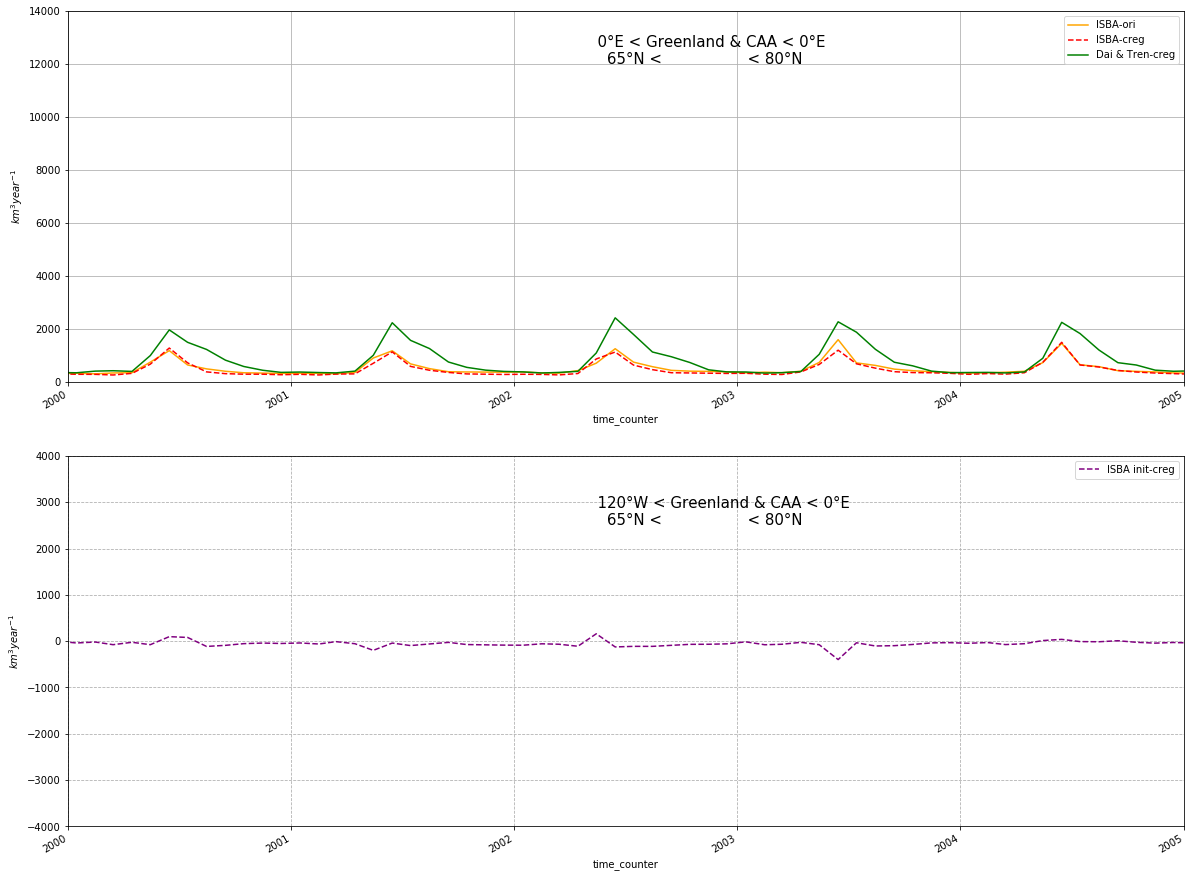

In [55]:
plt.figure(figsize=(20,15))

plt.subplot(211)
(ds_isbaref_Arc_mon['runoff_sum_Grca']*1e-9*365.*86400.).plot(color='orange',label='ISBA-ori')
(ds_rnf_mon['sorunoff_sum_Grca']*alpha).plot(color='r',linestyle='dashed',label='ISBA-creg')
(ds_DTBrnf_mon['sorunoff_sum_Grca']*alpha).plot(color='g',label='Dai & Tren-creg')
plt.text('2002.5',12000.,'  0°E < Greenland & CAA < 0°E \n    65°N <                  < 80°N', size=15)
plt.ylabel('$km{^3} year^{-1}$')
plt.xlim(['2000','2005'])
plt.ylim([0., 14000.])
plt.grid(True)
plt.legend()


plt.subplot(212)
(ds_rnf_mon['sorunoff_sum_Grca']*alpha-ds_isbaref_Arc_mon['runoff_sum_Grca']*1e-9*365.*86400.).plot\
(color='purple',linestyle='dashed',label='ISBA init-creg')
plt.text('2002.5',2500.,'  120°W < Greenland & CAA < 0°E \n    65°N <                  < 80°N', size=15)
plt.ylabel('$km{^3} year^{-1}$')
plt.xlim(['2000','2005'])
plt.ylim([-4000., 4000.])
plt.grid(True,linestyle='dashed')
plt.legend()


savefig=False
if savefig: plt.savefig('./FIGURES/Runoff_DAI_vs_ISBA_GreenlandCAA65N-80N-0E-120W_Monthly_y20002005.pdf')

> # ISBA original data over Alaska & Bering

In [70]:
ds_isbaref_Arc_Albe=xr.where(ds_isbaref['latitude']   < 65.,0.,ds_isbaref['rivdis'])
ds_isbaref_Arc_Albe=xr.where(ds_isbaref['latitude']   > 80.,0.,ds_isbaref_Arc_Albe)
ds_isbaref_Arc_Albe=xr.where(ds_isbaref['longitude'] < -180.,0.,ds_isbaref_Arc_Albe)
ds_isbaref_Arc_Albe=xr.where(ds_isbaref['longitude'] > -120.,0.,ds_isbaref_Arc_Albe)

In [71]:
ds_isbaref_Arc_Albe

<xarray.DataArray (longitude: 720, latitude: 360, time_counter: 14822)>
dask.array<shape=(720, 360, 14822), dtype=float64, chunksize=(720, 360, 365)>
Coordinates:
  * longitude     (longitude) float32 -179.75 -179.25 -178.75 ... 179.25 179.75
  * latitude      (latitude) float32 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * time_counter  (time_counter) datetime64[ns] 1979-01-01T12:00:00 ... 2019-07-31T12:00:00

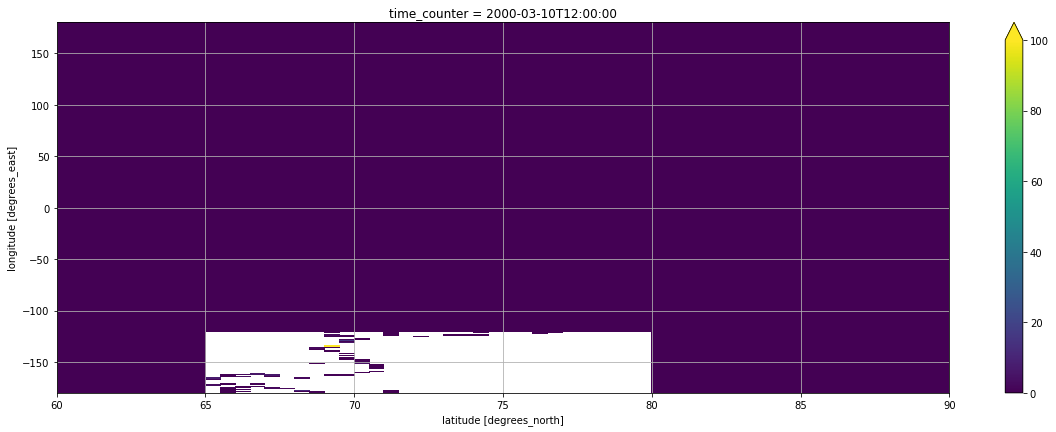

In [72]:
plt.figure(figsize=(20,15))
plt.subplot(211)
ds_isbaref_Arc_Albe.sel(time_counter='2000-03-10',latitude=slice(60,90)).plot(vmax=100.)
plt.grid(True)

In [73]:
ds_isbaref_daily['runoff_sum_Albe']=(('time_counter'),(ds_isbaref_Arc_Albe).sum(dim=['latitude','longitude']))
ds_isbaref_Arc_mon['runoff_sum_Albe']=(('time_counter'),ds_isbaref_daily['runoff_sum_Albe'].sel(time_counter=slice('1980-01','2015-12')).resample(time_counter='1M').mean())
ds_isbaref_Arc_year['runoff_sum_Albe']=(('time_counter'),ds_isbaref_Arc_mon['runoff_sum_Albe'].resample(time_counter='1Y').mean())

> # Define a box over the Alaska & Bering areas 

In [74]:
tmsk_ARC_ALBE=xr.where((ds_dfg['gphit'] <  65.), 0., tmask2D)
tmsk_ARC_ALBE=xr.where((ds_dfg['gphit'] >  80.), 0., tmsk_ARC_ALBE)
tmsk_ARC_ALBE=xr.where((ds_dfg['glamt'] < -180.), 0., tmsk_ARC_ALBE) 
tmsk_ARC_ALBE=xr.where((ds_dfg['glamt'] > -120.), 0., tmsk_ARC_ALBE) 

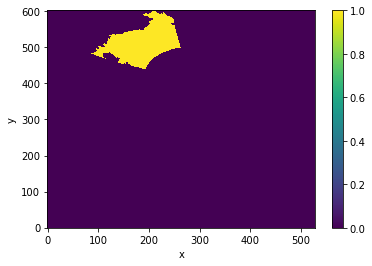

In [75]:
tmsk_ARC_ALBE.plot()

# > ISBA data over the Alaska & Bering areas

In [76]:
ds_rnf_daily['sorunoff_sum_Albe']=(('time_counter'),((ds_isbarnf['sorunoff'][:,:,:]*tmsk_ARC_ALBE[0,:,:]*\
                                                ds_dfg['e1t'].isel(t=0)*\
                                                ds_dfg['e2t'].isel(t=0))*1e-3).sum(dim=['x','y'])*1e-6)

ds_rnf_mon['sorunoff_sum_Albe']=(('time_counter'),ds_rnf_daily['sorunoff_sum_Albe'].resample(time_counter="1M").mean())

ds_rnf_year['sorunoff_sum_Albe']=(('time_counter'),ds_rnf_mon['sorunoff_sum_Albe'].resample(time_counter="1Y").mean())

# > Dai data over the Alaska & Bering areas

In [77]:
ds_DTBrnf_mon['sorunoff_sum_Albe']=(('time_counter'),((ds_DTBrnf['runoff'][:,:,:]*tmsk_ARC_ALBE[0,:,:]*\
                                                ds_dfg['e1t'].isel(t=0)*\
                                                ds_dfg['e2t'].isel(t=0))*1e-3).sum(dim=['x','y'])*1e-6)

ds_DTBrnf_year['sorunoff_sum_Albe']=(('time_counter'),ds_DTBrnf_mon['sorunoff_sum_Albe'].resample(time_counter="1Y").mean())

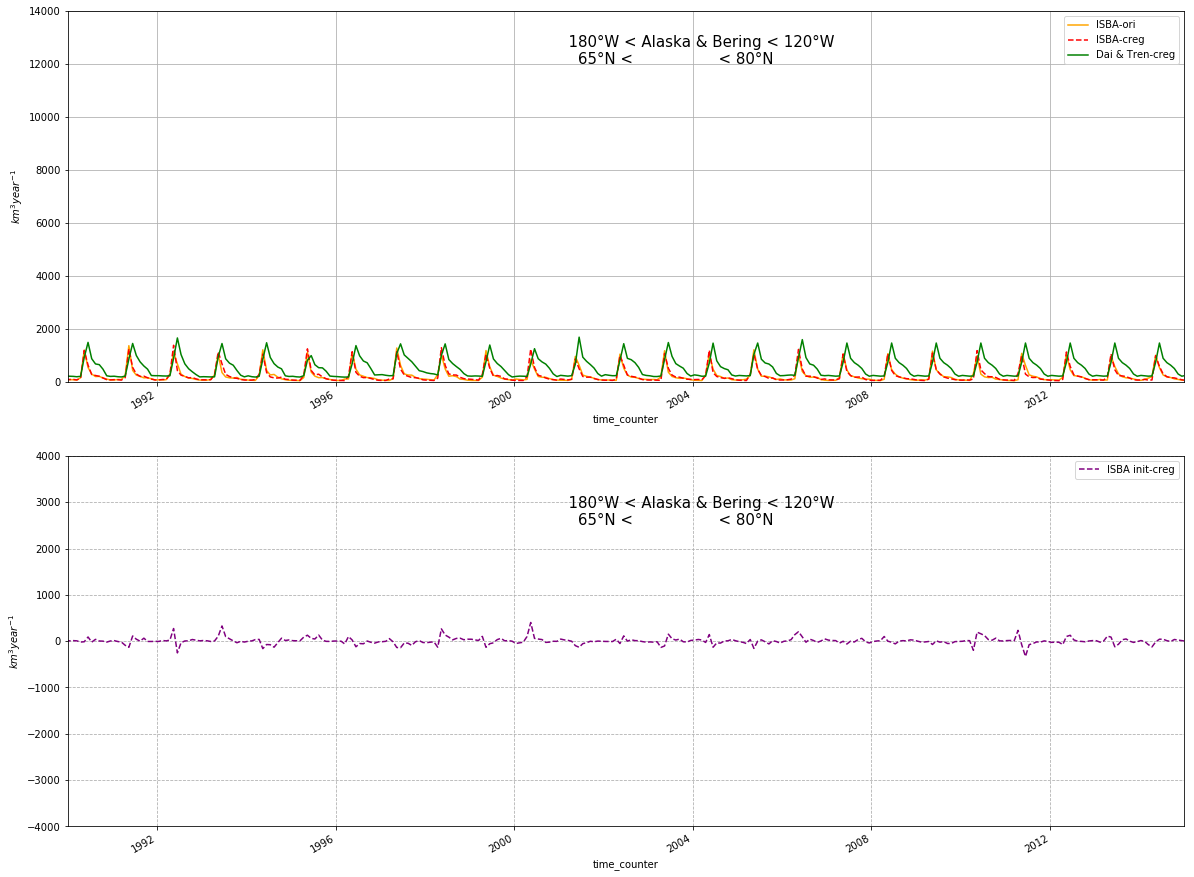

In [81]:
plt.figure(figsize=(20,15))

plt.subplot(211)
(ds_isbaref_Arc_mon['runoff_sum_Albe']*1e-9*365.*86400.).plot(color='orange',label='ISBA-ori')
(ds_rnf_mon['sorunoff_sum_Albe']*alpha).plot(color='r',linestyle='dashed',label='ISBA-creg')
(ds_DTBrnf_mon['sorunoff_sum_Albe']*alpha).plot(color='g',label='Dai & Tren-creg')
plt.text('2001.',12000.,'  180°W < Alaska & Bering < 120°W \n    65°N <                  < 80°N', size=15)
plt.ylabel('$km{^3} year^{-1}$')
plt.xlim(['1990','2015'])
plt.ylim([0., 14000.])
plt.grid(True)
plt.legend()

plt.subplot(212)
(ds_rnf_mon['sorunoff_sum_Albe']*alpha-ds_isbaref_Arc_mon['runoff_sum_Albe']*1e-9*365.*86400.).plot\
(color='purple',linestyle='dashed',label='ISBA init-creg')
plt.text('2001.',2500.,'  180°W < Alaska & Bering < 120°W \n    65°N <                  < 80°N', size=15)
plt.ylabel('$km{^3} year^{-1}$')
plt.xlim(['1990','2015'])
plt.ylim([-4000., 4000.])
plt.grid(True,linestyle='dashed')
plt.legend()

savefig=True
if savefig: plt.savefig('./FIGURES/Runoff_DAI_vs_ISBA_AlskaBering65N-80N-120W-180W_Monthly_y19902015.pdf')

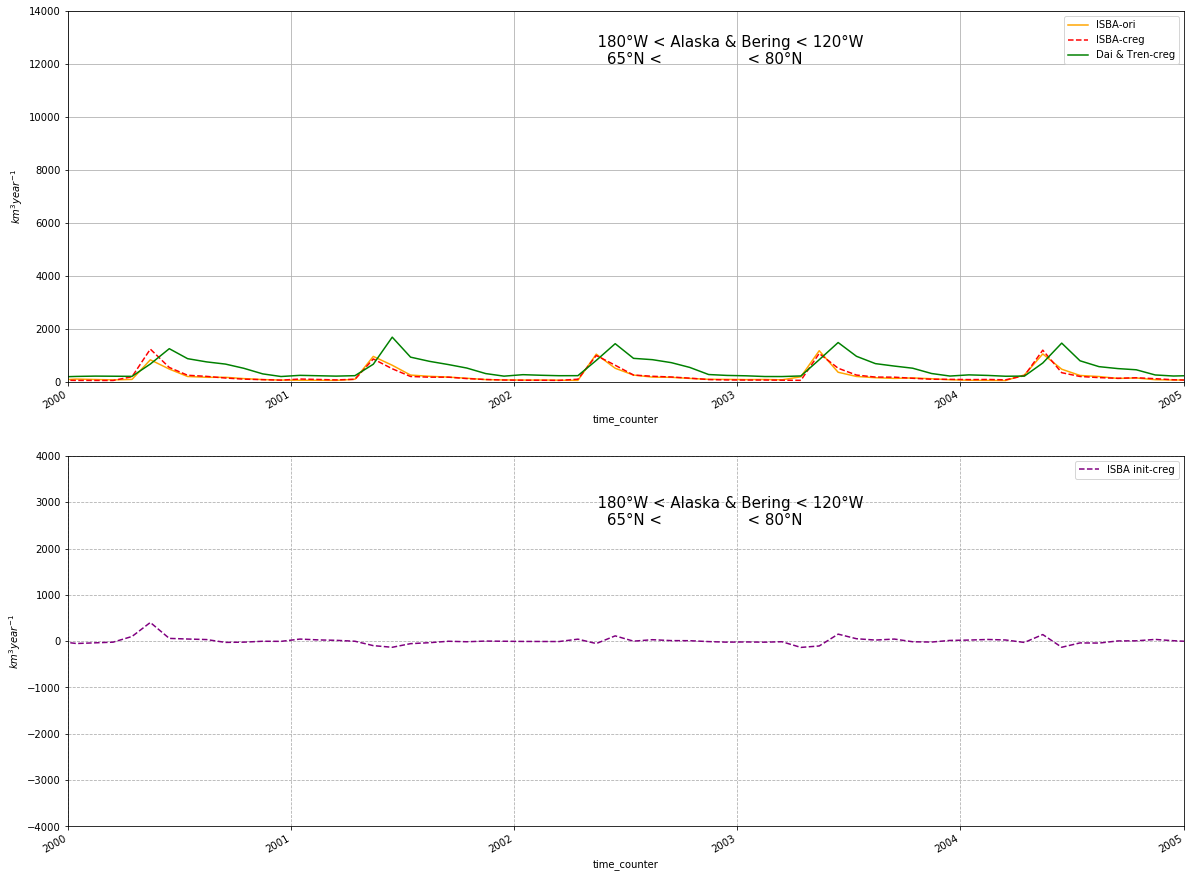

In [80]:
plt.figure(figsize=(20,15))

plt.subplot(211)
(ds_isbaref_Arc_mon['runoff_sum_Albe']*1e-9*365.*86400.).plot(color='orange',label='ISBA-ori')
(ds_rnf_mon['sorunoff_sum_Albe']*alpha).plot(color='r',linestyle='dashed',label='ISBA-creg')
(ds_DTBrnf_mon['sorunoff_sum_Albe']*alpha).plot(color='g',label='Dai & Tren-creg')
plt.text('2002.5',12000.,'  180°W < Alaska & Bering < 120°W \n    65°N <                  < 80°N', size=15)
plt.ylabel('$km{^3} year^{-1}$')
plt.xlim(['2000','2005'])
plt.ylim([0., 14000.])
plt.grid(True)
plt.legend()


plt.subplot(212)
(ds_rnf_mon['sorunoff_sum_Albe']*alpha-ds_isbaref_Arc_mon['runoff_sum_Albe']*1e-9*365.*86400.).plot\
(color='purple',linestyle='dashed',label='ISBA init-creg')
plt.text('2002.5',2500.,'  180°W < Alaska & Bering < 120°W \n    65°N <                  < 80°N', size=15)
plt.ylabel('$km{^3} year^{-1}$')
plt.xlim(['2000','2005'])
plt.ylim([-4000., 4000.])
plt.grid(True,linestyle='dashed')
plt.legend()


savefig=True
if savefig: plt.savefig('./FIGURES/Runoff_DAI_vs_ISBA_AlskaBering65N-80N-120W-180W_Monthly_y20002005.pdf')